# Testing Bomanz high-speed ADC

## Testing at 10MHz

Doing the tests with the [signal emulator](https://github.com/kelu124/echomods/tree/master/silent)

In [1]:
File = ["10MHz/10MHz_adc.csv","10MHz/grounded_right.csv","10MHz/grounded_left.csv","10MHz/10MHz_piezoNoBack.csv"]
import matplotlib.pyplot as plt
import numpy as np
from ADC08200 import CreateSeries
from scipy.signal import hilbert, chirp

## Testing the GND noise for both extremes of Vref 

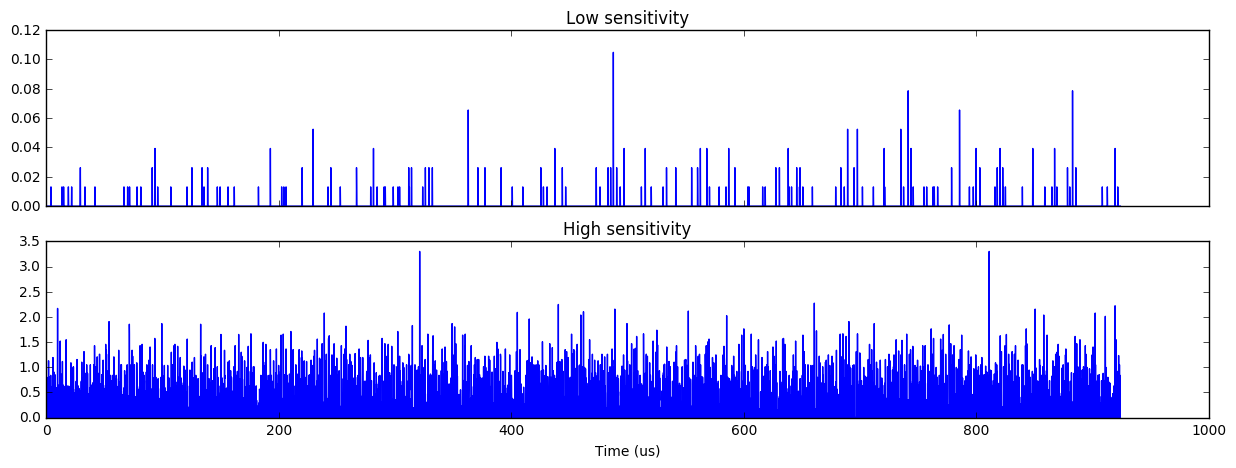

In [2]:
Res1, t1, N1 = CreateSeries(File[1],1000.0)
Res2, t2, N2 = CreateSeries(File[2],1000.0)

f, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(15,5))
ax1.plot(t1, Res1)
ax1.set_title('Low sensitivity')
plt.xlabel("Time (us)")
ax2.plot(t2, Res2)
ax2.set_title('High sensitivity')
plt.xlabel("Time (us)")
plt.show()

In [3]:
Res, t, N = CreateSeries(File[0],1000.0)

Testing if we get the raw signal as we thing we should

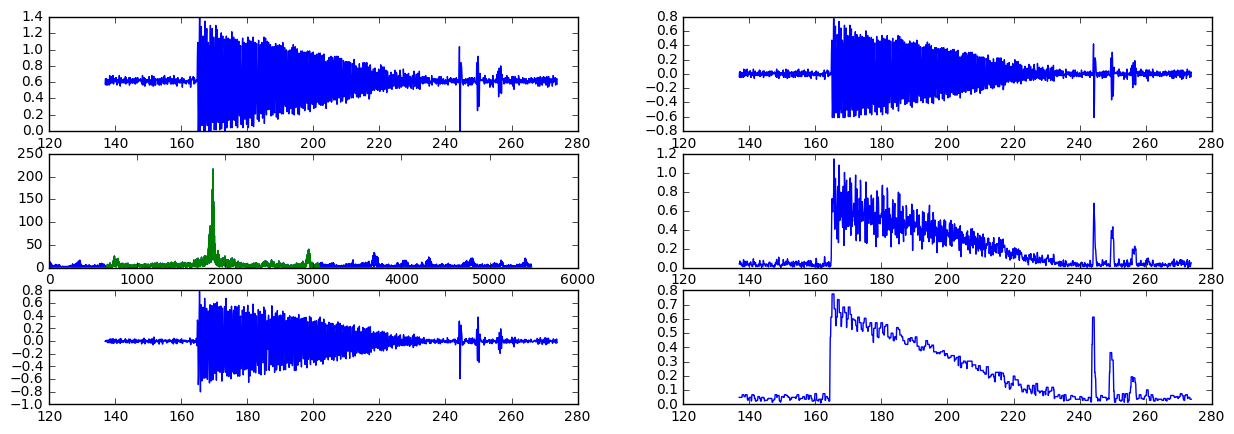

In [11]:
Res, t, N = CreateSeries(File[0],1000.0)
RefT = 1500

FFT = np.fft.fft(Res)
FFT[0]=0
Freqs = [1000.0 * x /N for x in range(5000)]

EmulFFTed = range(10000)
for k in range(5000):
    if ((k < 2800) and (k > 600)):
        EmulFFTed[k] = FFT[k]
        EmulFFTed[9999-k] = FFT[9999-k]
    else:
        EmulFFTed[k] = 0
        EmulFFTed[9999-k] = 0
EmulFFTed = np.asarray(EmulFFTed)
# We rebuild the signal
Rebuilt = np.fft.ifft(EmulFFTed)

Moyenne = np.average (Res)

## Hilbert
analytic_signal = hilbert(Res-Moyenne) #Res-Moyenne / Rebuilt
amplitude_envelope = np.abs(analytic_signal)

## Bivi Method
signal = abs(Res-Moyenne)
out = []
lenWindow = 6
for i in range(len(signal)-lenWindow):
    out.append(np.amax(signal[i:i+lenWindow]))

## Plotting
fig, ax = plt.subplots( nrows=3, ncols=2,figsize=(15,5))
ax[1,0].plot(Freqs,abs(FFT[0:5000]))  # plotting 50x 100ns, that's 5µs
ax[1,0].plot(Freqs,abs(EmulFFTed[0:5000]))  # plotting 50x 100ns, that's 5µs
ax[0,0].plot(t[RefT+0:RefT+1500],Res[RefT+0:RefT+1500])  # plotting 50x 100ns, that's 5µs
ax[2,0].plot(t[RefT+0:RefT+1500],Rebuilt[RefT+0:RefT+1500])  # plotting 50x 100ns, that's 5µs
ax[0,1].plot(t[RefT+0:RefT+1500],Res[RefT+0:RefT+1500]-Moyenne)  # plotting 50x 100ns, that's 5µs
ax[1,1].plot(t[RefT+0:RefT+1500],amplitude_envelope[RefT+0:RefT+1500])  # plotting 50x 100ns, that's 5µs
ax[2,1].plot(t[RefT+0:RefT+1500],out[RefT+0:RefT+1500])  # plotting 50x 100ns, that's 5µs


plt.show()

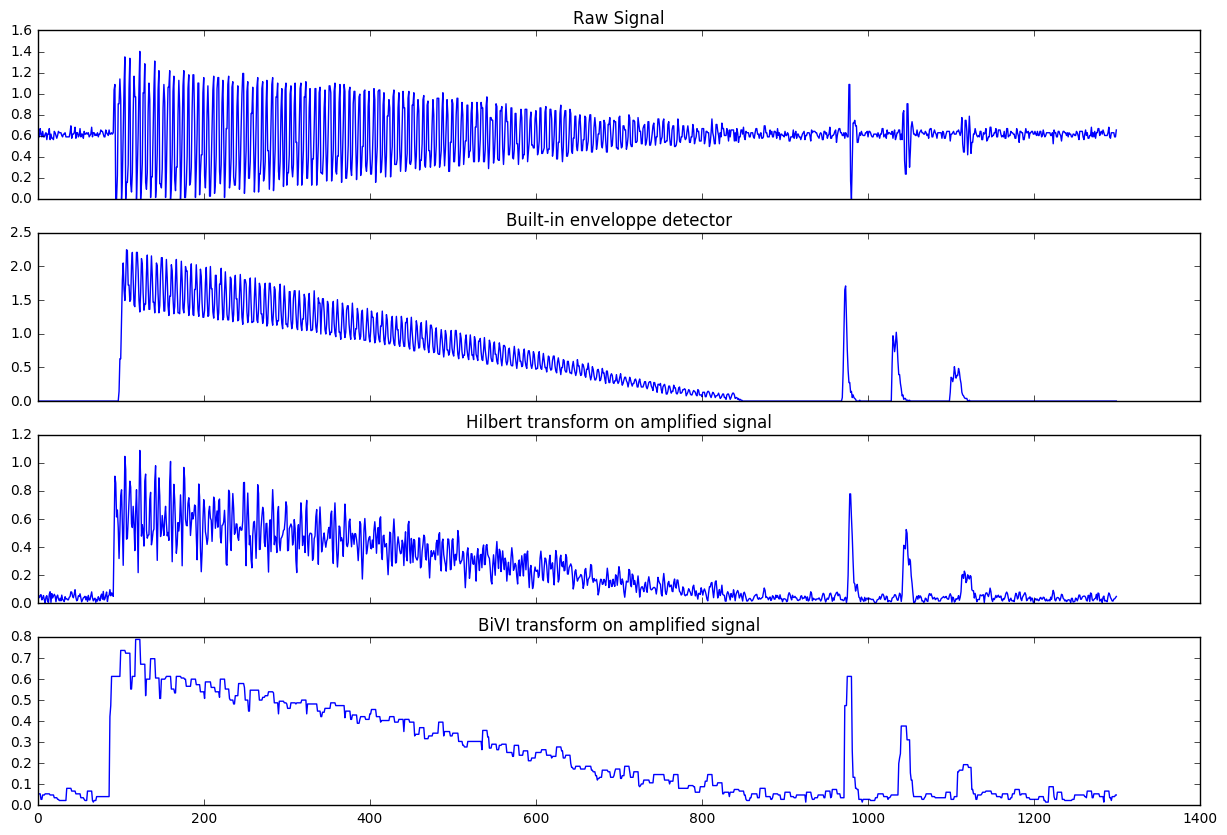

In [12]:
EnveloppeGoblin = ["10MHz/20170501-ADC08_env.data"]

ResEnv, tE, N = CreateSeries(EnveloppeGoblin[0],1000.0)

NbFiles = 4
f, Array = plt.subplots(NbFiles, sharex=True,figsize=(15,10))
  
Array[0].plot(Res[7400:8700])
Array[0].set_title('Raw Signal')
Array[1].plot(ResEnv[7000:8300])
Array[1].set_title('Built-in enveloppe detector')
Array[2].plot(amplitude_envelope[7400:8700])
Array[2].set_title('Hilbert transform on amplified signal')
Array[3].plot(out[7400:8700])
Array[3].set_title('BiVI transform on amplified signal')

f.savefig('../images/DifferentEnveloppes.jpg')

plt.show()

## Comparing with [Croaker](https://github.com/kelu124/echomods/tree/master/croaker/)

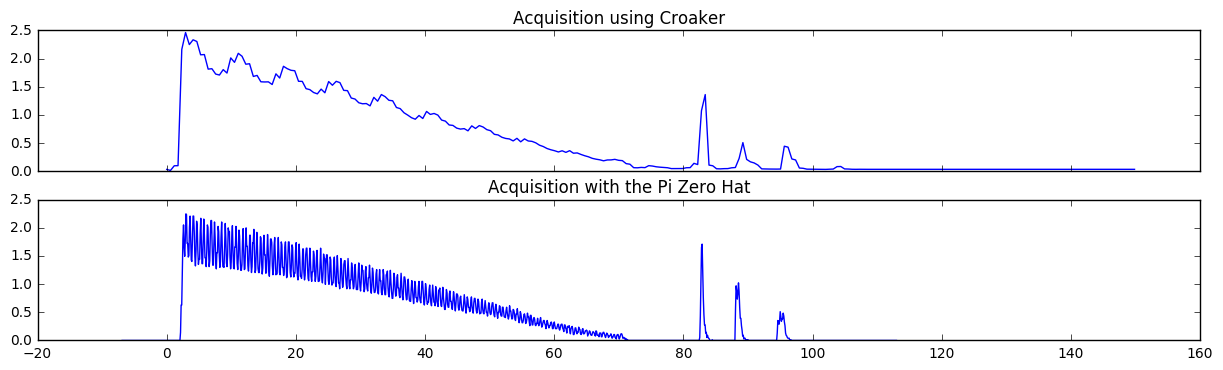

In [6]:
CroakerAcq = "../../croaker/data/20170501-NC-LU-Silent.data"
with open(CroakerAcq) as f:
    content = f.readlines()
NbFiles = 2
LigneCroaker = np.asarray(content[1].strip().split(";"), dtype=np.float32)
f, Array = plt.subplots(NbFiles, sharex=True,figsize=(15,4))
Array[0].plot(np.asarray(range(len(LigneCroaker)))/1.715,LigneCroaker*0.001)
Array[0].set_title('Acquisition using Croaker')
Array[1].plot(tE[7000:8300]-653,ResEnv[7000:8300])
Array[1].set_title('Acquisition with the Pi Zero Hat')
plt.show()

# Testing with a crappy (real piezo) situation

Real piezo, with some backing, put in a glass of water

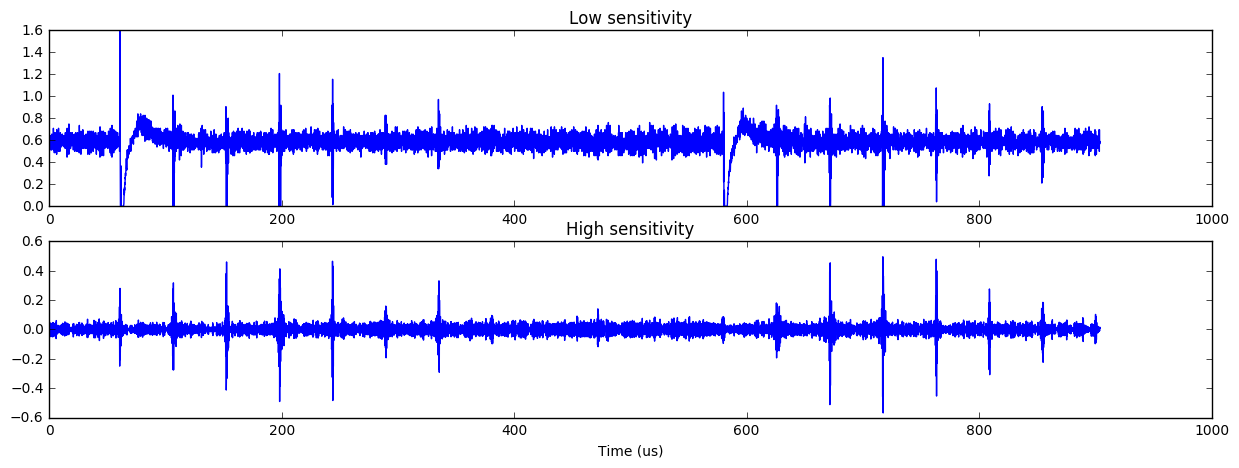

In [7]:
Res, t, N = CreateSeries("10MHz/10MHz_tasse_smartmaterials.csv",1000.0)
RefT = 50*10

# FFT
FFT = np.fft.fft(Res)
FFT[0]=0
Freqs = [1000.0 * x /N for x in range(5000)]
Sorted = range(10000)
for k in range(5000):
    if ((k < 2600) and (k > 1400)):
        Sorted[k] = FFT[k]
        Sorted[9999-k] = FFT[9999-k]
    else:
        Sorted[k] = 0
        Sorted[9999-k] = 0
# We rebuild the signal
Rebuilt = np.fft.ifft(Sorted)

# Plotting
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,5))
ax1.plot(t,Res)
ax1.set_title('Low sensitivity')
plt.xlabel("Time (us)")
ax2.plot(t, Rebuilt)
ax2.set_title('High sensitivity')
plt.xlabel("Time (us)")
plt.show()

#### Details for echoes =)

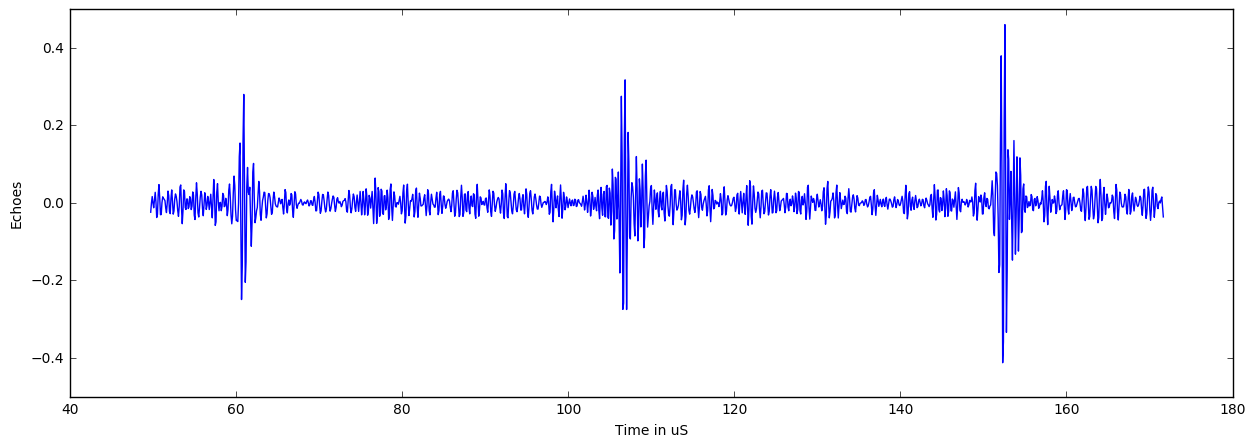

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(t[550:1900],Rebuilt[550:1900])  # plotting 50x 100ns, that's 5µs
plt.ylabel('Echoes')
plt.xlabel("Time in uS")
plt.show()

## Testing with a piezo with no backing

The aim of this block is to see what happens if we excite an unknown piezo, without backing, with a 10V pulse.

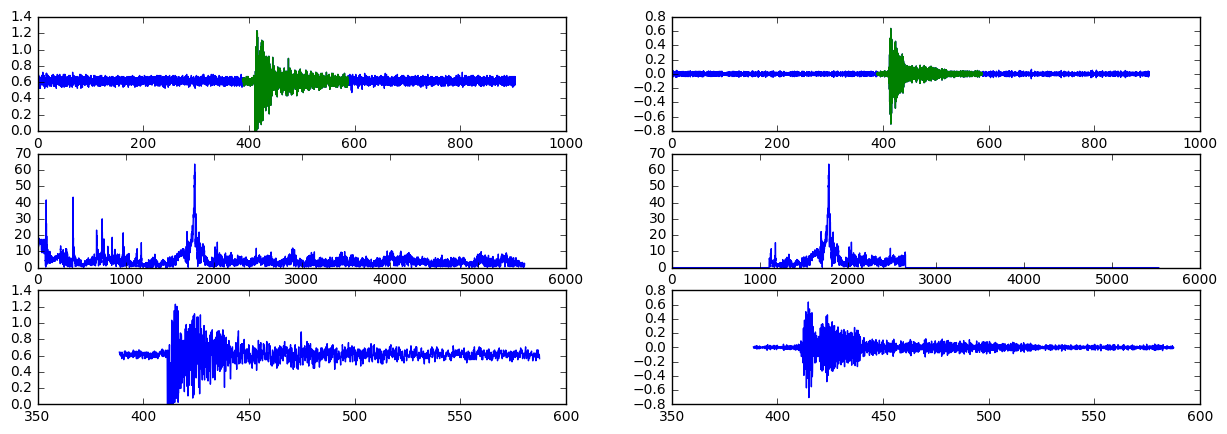

In [9]:
Res, t, N = CreateSeries(File[3],1000.0)
RefT = 1500
N = t[-1]
FFT = np.fft.fft(Res)
FFT[0]=0
Freqs = [1000.0 * x /N for x in range(5000)]

## Cleaning frequency
SortedNoBack = range(10000)
for k in range(5000):
    if ((k < 2400) and (k > 1000)):
        SortedNoBack[k] = FFT[k]
        SortedNoBack[9999-k] = FFT[9999-k]
    else:
        SortedNoBack[k] = 0
        SortedNoBack[9999-k] = 0
SortedNoBack = np.asarray(SortedNoBack)
# We rebuild the signal
Rebuilt = np.fft.ifft(SortedNoBack)

## Plotting
fig, ax = plt.subplots( nrows=3, ncols=2,figsize=(15,5))
ax[1,0].plot(Freqs,abs(FFT[0:5000]))  # plotting 50x 100ns, that's 5µs
ax[0,0].plot(t,Res)  # plotting 50x 100ns, that's 5µs
ax[0,0].plot(t[4300:6500],Res[4300:6500])  # plotting 50x 100ns, that's 5µs
ax[2,0].plot(t[4300:6500],Res[4300:6500])  # plotting 50x 100ns, that's 5µs
ax[1,1].plot(Freqs,abs(SortedNoBack[0:5000]))  # plotting 50x 100ns, that's 5µs
ax[0,1].plot(t,Rebuilt)  # plotting 50x 100ns, that's 5µs
ax[0,1].plot(t[4300:6500],Rebuilt[4300:6500])  # plotting 50x 100ns, that's 5µs
ax[2,1].plot(t[4300:6500],Rebuilt[4300:6500])  # plotting 50x 100ns, that's 5µs
fig.savefig('../images/PiezoNoBacking.jpg')
plt.show()